In [7]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import norm
import yfinance as yf
import pandas as pd

%matplotlib inline

Plan financial engineering expo 1

Grp 1 : 

Product (7 slides) : overall presentation, Benefit and risk, Best and worst scenario (variation sous jacent, coupons, taux de change), 

Market (5 slides): historical trend du sous-jacent, du taux de change utilisé

Modeling (19 slides) : equations de modélisation (local volatility framework), SABR Model for implied volatility, conversion from implied volatility to local volatility, GBM, instantaneous Covariance Structure, Model Risk and Simplifying assumptions (correlation risk is constant, distribution risk are normally distributed, fees and embedded costs are not explicitly included in price, …), validity test (test of normality), implications of deviations from normality (fat tail, …), Historical dependency between assets, justification of the constant correlation assumption

Calibration (15 slides) : Yield curve construction (cubic spline interpolation), interpolated risk-free yield curves, Computation of empirical covariance and correlation, estimated volatility and correlation, the way to calibrate local volatile surface, implied volatility via BS Inversion (Brent’s method), SABR model calibration (quantLib.SABRInterpolation using the Levenberg-Marquardt algorithm), SABR Implied volatility surface (short and long maturity), from SABR surface to local volatility (Time derivative, strike derivatives)

Pricing methodology (8 slides) : forward rates calculation, discretization of asset dynamics (model setup), Random number generation for simualtion for MC and QMC (and comparaison of the methods),  fair value based on an initial investment of 1M JPY (gap correspond to insurance cost), convergence comparaison of MC and QMC (MC_SolSurf_P, Halton_sim, …)

Q-mesure (6 slides) : ? 

P-mesure : comparaison with Q-mesure (unimodal vs bimodal distribution = Historical data vs implied volatility)

Analysis : Fair value comparaison (Q-mesure), Fat tails in Nikkei 225 returns (QQ-plot), Volatility Smile (SABR implied volatility surface), why impact of fair value so small (/!\ pa sur qu’on ait ça nous), Scenario Breakdown (where payoff land)

Conclusion : Recap, We we buy this product, futur work (Dimension reduction via Brownian Bridge)

## Product :

- overall presentation
- Benefits and risks
- Best and worst scenario (variation du sous jacent, coupons, taux de change)

Les principales caractéristiques sont :

Coupon Phoenix avec mémoire : 2,25 % trimestriel si tous les sous-jacents > 60 % du niveau initial à une date de constatation.
Autocall trimestriel discret : remboursement anticipé si le worst-of dépasse une barrière décroissante (de 85 % à 60 %) à des dates trimestrielles.
Protection conditionnelle du capital : remboursement à 100 % si le worst-of ne passe jamais sous 30 % à maturité.

 Avantages
Coupon attractif avec mémoire : 2,25 % trimestriel même après des périodes sans versement si condition remplie.
Autocall potentiellement rapide : si les marchés montent, remboursement anticipé possible dès 1 an.
Effet de "barrière européenne" : la protection en capital est assurée si le worst-of ne passe pas sous 30 % à l’échéance.

Risques
Perte en capital possible si le worst-of < 30 % à maturité → remboursement réduit proportionnellement.
Sensibilité au pire sous-jacent : même si 3 actions performent bien, une seule peut annuler coupons + protection.
Absence de marché secondaire liquide : faible liquidité possible.
Pas de dividendes sur les actions sous-jacentes.
Complexité du produit et dépendance au pricing interne de Barclays.

🔼 Scénario optimiste
Le worst-of reste au-dessus de la barrière autocall (ex : > 85 %) dès avril 2026.
Remboursement anticipé à 100 % + 4 coupons de 2,25 %, soit 109 % en EUR après 1 an.
🔁 Mais : si l’euro se déprécie par rapport au yen (ex. EUR/JPY passe de 160 à 140), le rendement en JPY est diminué :

🔽 Scénario pessimiste
Le worst-of clôture < 30 % à l’échéance (avril 2035).
Aucun coupon versé.
Remboursement à 25 % (si worst-of = -75 %) = 250 EUR.
💸 En JPY : si l’euro a perdu de la valeur, la perte en yen est encore plus importante.
Si l’euro a monté, cela peut limiter la perte, mais pas l’éviter.

Conclusion sur le taux de change (EUR/JPY)
Le risque de change est réel pour un investisseur japonais.
Il peut renforcer ou aggraver le rendement final.
Le produit est non couvert contre le risque de change.
Une couverture (hedging) EUR/JPY pourrait être envisagée si l’investisseur souhaite neutraliser cet effet.

## Market : 

- taux de change utilisé
- historical trend du sous jacent


/var/folders/k6/tkt2xb056ksgrwnd0n53bzgw0000gn/T/ipykernel_4520/1827673933.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  eurjpy = yf.download("EURJPY=X")["Close"]
[*********************100%***********************]  1 of 1 completed


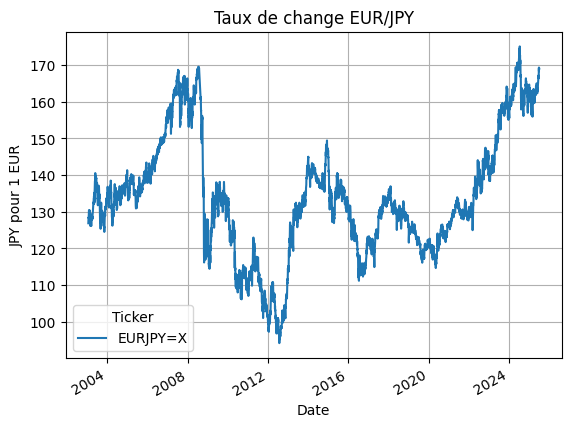

In [8]:
eurjpy = yf.download("EURJPY=X")["Close"]

# Tracer le taux de change
eurjpy.plot(title="Taux de change EUR/JPY")
plt.xlabel("Date")
plt.ylabel("JPY pour 1 EUR")
plt.grid(True)
plt.show()

In [9]:
tickers = ['TTE.PA', 'ASML', 'EN.PA', 'RI.PA']
data = yf.download(tickers, start="2022-01-01", end="2025-06-15")

/var/folders/k6/tkt2xb056ksgrwnd0n53bzgw0000gn/T/ipykernel_4520/3597107769.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start="2022-01-01", end="2025-06-15")
[*********************100%***********************]  4 of 4 completed


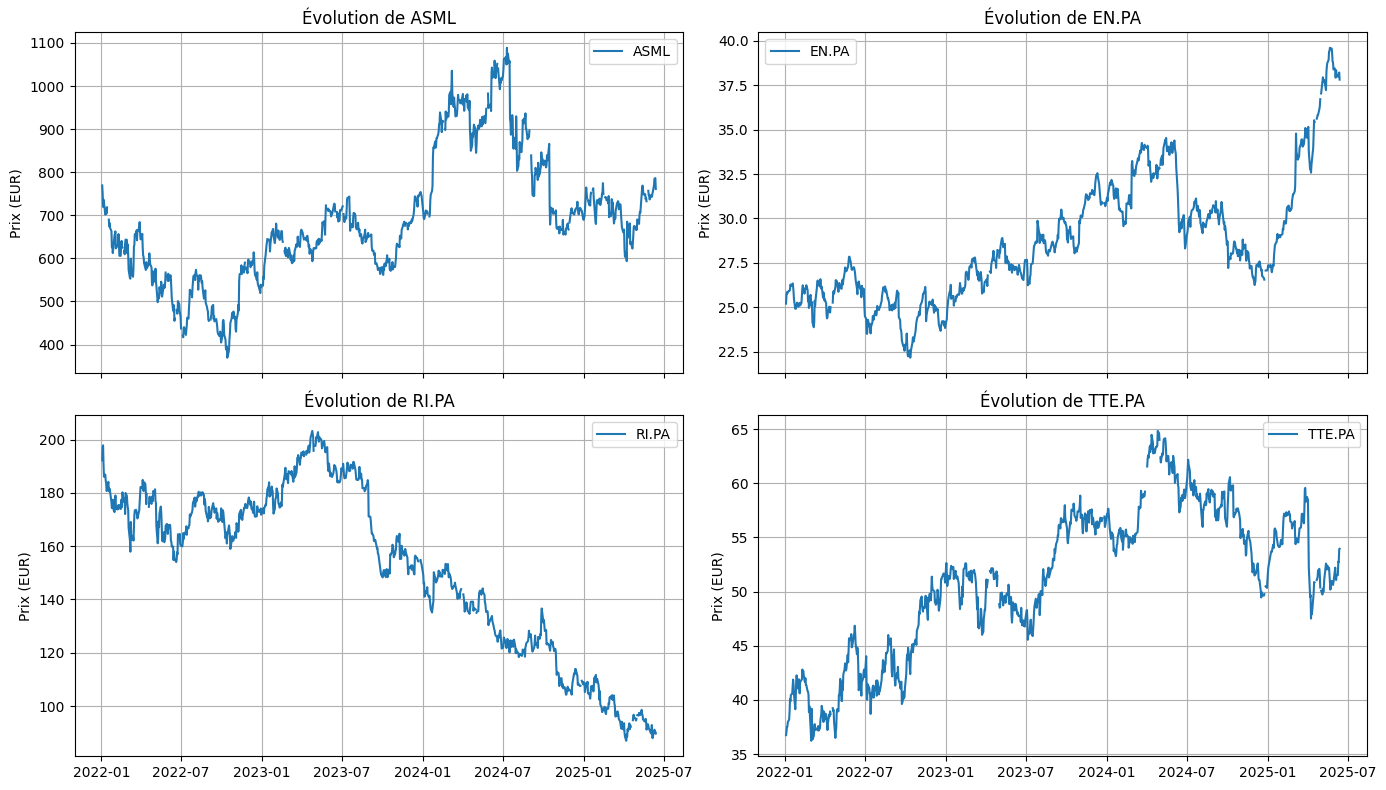

In [13]:
# Extraire uniquement les prix de clôture
close_prices = data.xs('Close', axis=1, level='Price')

# Tracer 4 courbes sur 4 sous-graphes
fig, axs = plt.subplots(2, 2, figsize=(14, 8), sharex=True)
axes = axs.flatten()

for i, ticker in enumerate(close_prices.columns):
    axes[i].plot(close_prices.index, close_prices[ticker], label=ticker)
    axes[i].set_title(f"Évolution de {ticker}")
    axes[i].set_ylabel("Prix (EUR)")
    axes[i].grid(True)
    axes[i].legend()

plt.tight_layout()
plt.show()

## Model :

In [ ]:
#Volatilité
close_prices = data.xs('Close', axis=1, level='Price')
returns = close_prices.pct_change().dropna()
vol = returns.std() * np.sqrt(252)
print(vol)


Ticker
ASML      0.430271
EN.PA     0.191624
RI.PA     0.238736
TTE.PA    0.251151
dtype: float64


/var/folders/k6/tkt2xb056ksgrwnd0n53bzgw0000gn/T/ipykernel_4520/1693314136.py:3: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = close_prices.pct_change().dropna()


In [ ]:
#Corrélation

close_prices = data['Close']

log_returns = np.log(close_prices / close_prices.shift(1)).dropna()
correlation_matrix = log_returns.corr()

print(correlation_matrix)

Ticker      ASML     EN.PA     RI.PA    TTE.PA
Ticker                                        
ASML    1.000000  0.139534  0.191271  0.135420
EN.PA   0.139534  1.000000  0.258970  0.303963
RI.PA   0.191271  0.258970  1.000000  0.160408
TTE.PA  0.135420  0.303963  0.160408  1.000000
